In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn import preprocessing
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from matplotlib.dates import SecondLocator
import datetime
import bs4

In [2]:
with open("100.json") as hundred:
    data = json.load(hundred)

In [12]:
def hr_summary(location, hr, ann, timeratio, ratio):
    def convert(n):
        dt = datetime.datetime.strptime('0', '%M')
        dt = dt + datetime.timedelta(seconds=n)
        return dt

    scatter_fhr = pd.DataFrame([location, hr, ann],
                               index=['time', 'bpm', 'beat_ann']).T
    scatter_fhr['time'] = (scatter_fhr['time'] * timeratio * ratio) / 1000
    scatter_fhr['time'] = scatter_fhr['time'].apply(convert)

    fig, ax = plt.subplots(1, figsize=(14, 4))
    ax.scatter(scatter_fhr[scatter_fhr['beat_ann'] == 'V']['time'],
               scatter_fhr[scatter_fhr['beat_ann'] == 'V']['bpm'],
               marker='s', label='Ventricular Ectopics', c='red', s=10)
    ax.scatter(scatter_fhr[scatter_fhr['beat_ann'] == 'A']['time'],
               scatter_fhr[scatter_fhr['beat_ann'] == 'A']['bpm'],
               marker='s', label='Atrial Ectopics', c='blue', s=10)
    ax.scatter(scatter_fhr[scatter_fhr['beat_ann'] == 'N']['time'],
               scatter_fhr[scatter_fhr['beat_ann'] == 'N']['bpm'],
               marker='s', label='Heart Rate', c='green', s=10)

    ax.set_xlim(datetime.datetime.strptime('0', '%M')
                , datetime.datetime.strptime('0', '%M') + datetime.timedelta(minutes=32))
    ax.set_ylim(0, 200)

    plt.xticks([datetime.datetime.strptime('0', '%M') + datetime.timedelta(minutes=2 * n) for n in
                range(17)],
               [(datetime.datetime.strptime('0', '%M') + datetime.timedelta(
                   minutes=2 * n)).strftime("%H:%M:%S") for n in range(17)])

    ax.set_ylabel('bpm')
    ax.set_xlabel('Time')

    ax.xaxis.set_minor_locator(SecondLocator(interval=20))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerfirst=False)
    ax.set_axisbelow(True)
    plt.grid(b=True, which='major', color='#ff0000', linestyle='-', lw=0.7)
    plt.grid(b=True, which='minor', color='#cf2d21', linestyle='-', alpha=0.5, lw=0.3)

    plt.tight_layout(pad=0.5)
    # plt.savefig(img)
    # plt.show(block=False)
    # plt.pause(3)
    # plt.close()

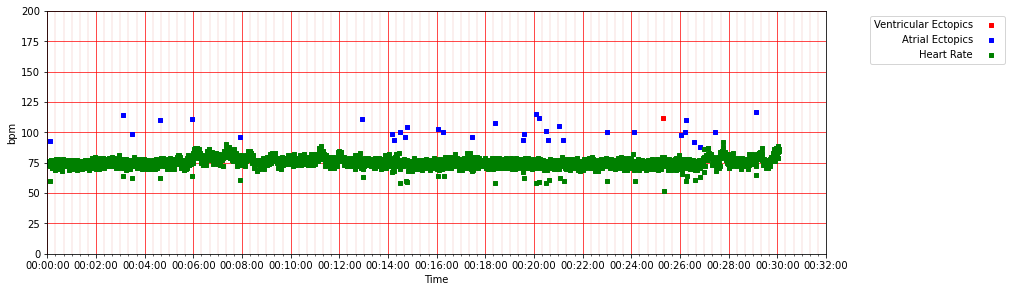

In [13]:
hr_summary(data['HRcart']['beat_location'], data['HRcart']['F_HR'], 
           data['HRcart']['Beat_ann'], data['HRcart']['timeRatio'], 
           data['HRcart']['ratio'])

In [5]:
def stackbar_plot(plot):
    ls = plot
    ls1 = []
    for x in ls:
        ls1.append(x.split(" : "))
    df = pd.DataFrame(ls1, columns=['bar', 'value'])
    df['value'] = df['value'].apply(lambda u: float(u[:-1]))

    fig, ax = plt.subplots(1, figsize=(6, 3))
    ax.set_xlim(0, 7)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_major_locator(MultipleLocator(10))

    plt.bar(0, df[df['bar'] == 'Sinus Rhythm']['value'], width=1, color='blue',
            label='Sinus Rhythm')

    plt.bar(0, df[df['bar'] == 'Atrial Fibrillation']['value'], width=1, color='yellow',
            bottom=float(df[df['bar'] == 'Sinus Rhythm']['value']), label='Atrial Fibrillation')

    plt.bar(0, df[df['bar'] == 'Tachycardia (>100 bpm)']['value'], width=1, color='green',
            bottom=float(df[df['bar'] == 'Sinus Rhythm']['value']) +
                   float(df[df['bar'] == 'Atrial Fibrillation']['value']),
            label='Tachycardia (>100 bpm)')

    plt.bar(0, df[df['bar'] == 'Bradycardia (<60 bpm)']['value'], width=1, color='red',
            bottom=float(df[df['bar'] == 'Sinus Rhythm']['value']) +
                   float(df[df['bar'] == 'Atrial Fibrillation']['value']) +
                   float(df[df['bar'] == 'Tachycardia (>100 bpm)']['value']),
            label='Bradycardia (<60 bpm)')

    plt.ylabel("Percentage %")
    plt.legend(loc='upper center', markerfirst=False, prop={'size': 8})

    plt.tight_layout(pad=0.5)
    # plt.savefig(img)
    # plt.show(block=False)
    # plt.pause(3)
    # plt.close()

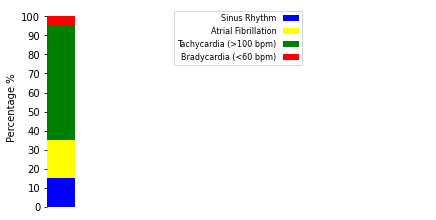

In [6]:
stackbar_plot(data['bargraph_details'])

In [14]:
def plot_rate(plots, title, summary, location, hr):
    df = pd.DataFrame(plots)
    x_major_locator = df.shape[0] / 30
    x_minor_locator = x_major_locator / 5
    y_minor_locator = 0.1

    x = np.arange(0, len(plots))
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    normalized_np = scaler.fit_transform(df)

    fig, ax = plt.subplots(1, figsize=(15, 3))
    fig.suptitle('Occurrence of %s Heart Rate (%s)' % (title, summary), size=10, c="#0041DC",
               fontweight='bold', y=0.96)
    # soup_replace(id, summary)
    ax.set_ylabel('Amplitude')

    ax.plot(x, normalized_np, color='black', lw='1')

    ax.xaxis.set_major_locator(MultipleLocator(x_major_locator))
    ax.xaxis.set_major_formatter(FormatStrFormatter(''))
    ax.xaxis.set_minor_locator(MultipleLocator(x_minor_locator))
    ax.yaxis.set_minor_locator(MultipleLocator(y_minor_locator))

    plt.xlim([0, df.shape[0]])
    plt.ylim([-1.1, 1.3])
    plt.grid(b=True, which='major', color='#ff0000', linestyle='-', lw=0.7)
    plt.grid(b=True, which='minor', color='#cf2d21', linestyle='-', alpha=0.5, lw=0.3)
    ax.set_axisbelow(True)

    for i in range(1, len(location)):
        # plt.arrow(location[i - 1], 0, (location[i] - location[i - 1]), 0, head_width=0.06,
        # head_length=7, linewidth=1.5, color='blue', length_includes_head=True)
        plt.arrow(location[i], 0, -(location[i] - location[i - 1]), 0, head_width=0.08,
                  head_length=7, linewidth=1, color='blue', length_includes_head=True)
        ax.text(((location[i - 1] + location[i]) / 2) - 20, -0.3, f'HR: {hr[i - 1]}', fontsize=10,
                color='blue')

    plt.tight_layout(pad=0.5)
    # plt.savefig(img)
    # plt.show(block=False)
    # plt.pause(3)
    # plt.close()

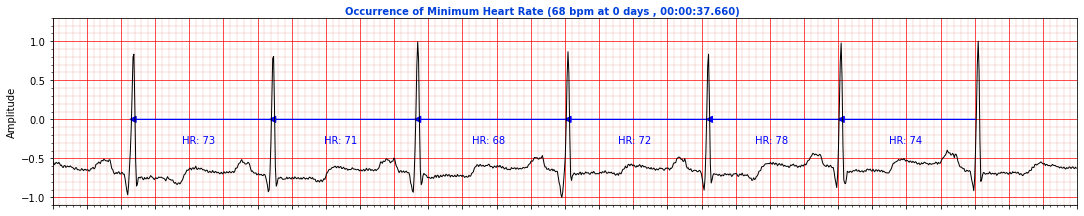

In [15]:
plot_rate(data['MinHR']['data'], 'Minimum' , data['Summary']['minHR'], data['MinHR']['location'],
          data['MinHR']['HR'])

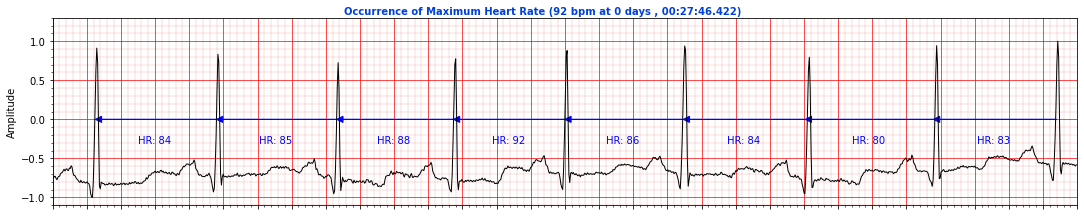

In [16]:
plot_rate(data['MaxHR']['data'], 'Maximum', data['Summary']['maxHR'], data['MaxHR']['location'],
          data['MaxHR']['HR'])

In [18]:
def plot_rhy(plots, location, noise_hr, beat_ann, p_wave_location, rhy_type):
    hr = [x.split("_")[2] for x in noise_hr]

    df = pd.DataFrame(plots)
    x_major_locator = df.shape[0] / 30
    x_minor_locator = x_major_locator / 5
    y_minor_locator = 0.1

    x = np.arange(0, len(plots))
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    normalized_np_min = scaler.fit_transform(df)

    fig, ax = plt.subplots(1, figsize=(15, 3))
    fig.suptitle(rhy_type, size=10, c="#0041DC", fontweight='bold', y=0.96)
    ax.set_ylabel('Amplitude')

    ax.plot(x, normalized_np_min, color='black', lw='1')

    ax.xaxis.set_major_locator(MultipleLocator(x_major_locator))
    ax.xaxis.set_major_formatter(FormatStrFormatter(''))
    ax.xaxis.set_minor_locator(MultipleLocator(x_minor_locator))
    ax.yaxis.set_minor_locator(MultipleLocator(y_minor_locator))

    plt.xlim([0, len(plots)])
    plt.ylim([-1.1, 1.3])
    plt.grid(b=True, which='major', color='#ff0000', linestyle='-', lw=0.7)
    plt.grid(b=True, which='minor', color='#cf2d21', linestyle='-', alpha=0.5, lw=0.3)
    ax.set_axisbelow(True)

    for i in range(1, len(location)):
        # plt.arrow(location[i - 1], 0, (location[i] - location[i - 1]), 0, head_width=0.06,
        # head_length=7, linewidth=1.5, color='blue', length_includes_head=True)
        plt.arrow(location[i], 0, -(location[i] - location[i - 1]), 0, head_width=0.1,
                  head_length=7, linewidth=1, color='blue', length_includes_head=True)
        ax.text(((location[i - 1] + location[i]) / 2) - 20, -0.3, f'HR: {hr[i]}', fontsize=10,
                color='blue')
        if beat_ann[i] == 'N' and beat_ann[i - 1] == 'N':
            ax.text(((location[i - 1] + location[i]) / 2) - 10, 1.1, 'Reg', fontsize=9,
                    color='blue')

    for i in range(0, len(location)):
        ax.text(location[i], 1, beat_ann[i], fontsize=10, color='black')

    for i in range(0, len(p_wave_location)):
        if beat_ann[i] == 'N' and p_wave_location[i] != 0:
            ax.text(p_wave_location[i], 0.7, 'P', fontsize=10, color='red')

    plt.tight_layout(pad=0.5)
    # plt.savefig(img)
    # plt.show(block=False)
    # plt.pause(3)
    # plt.close()

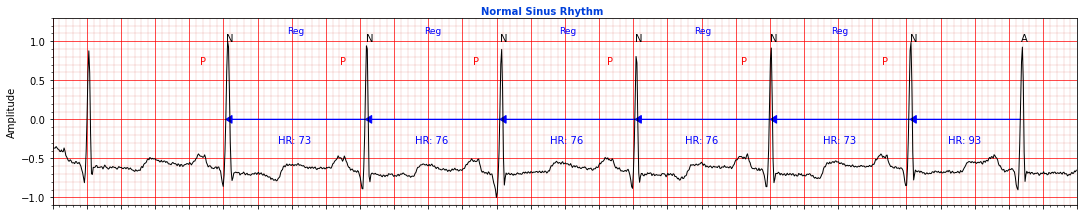

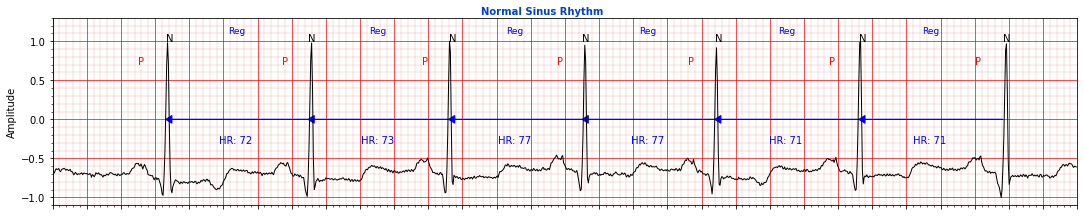

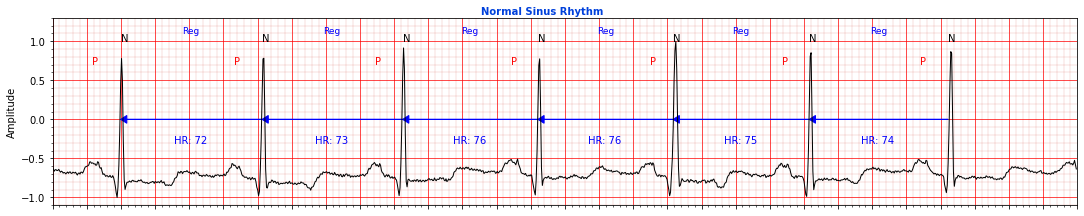

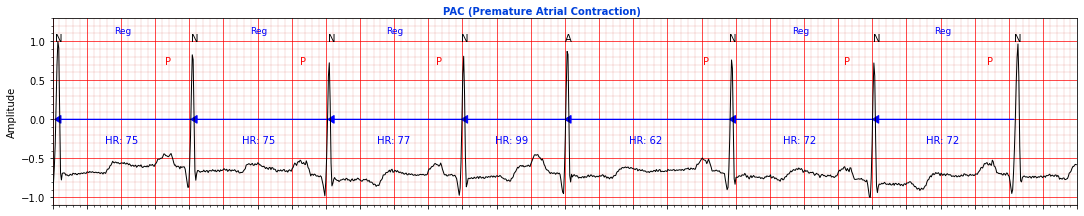

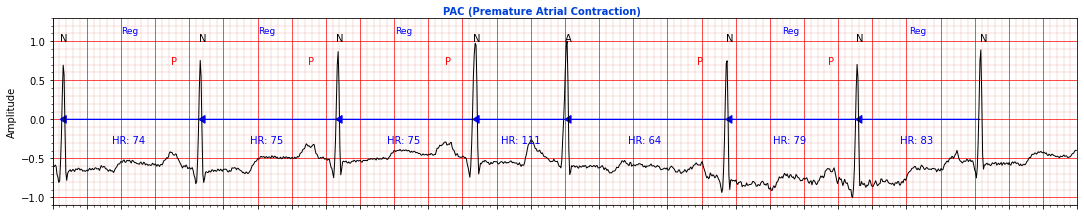

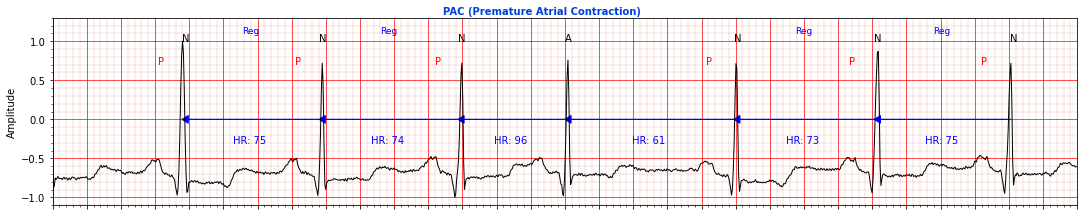

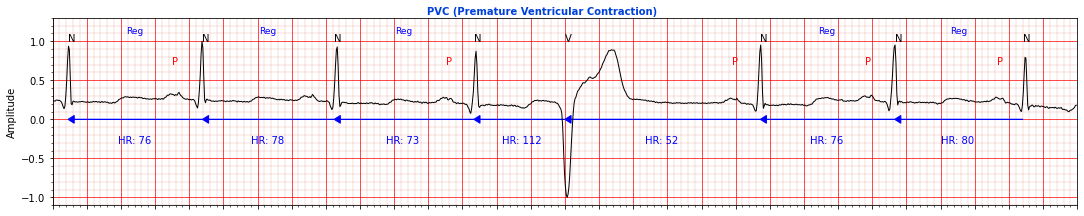

In [19]:
for i in range(0, len(data['Rhy_details'])):
    for j in range(0, len(data['Rhy_details'][i])):
        for k in range(0, len(data['Rhy_details'][i][j]['data'])):
            if data['Rhy_details'][i][j]['RHY'] != "" and (k < 3):  # each rhythm 3 samples
                plot_rhy(data['Rhy_details'][i][j]['data'][k]['data'],
                         data['Rhy_details'][i][j]['data'][k]['location'],
                         data['Rhy_details'][i][j]['data'][k]['Noise_HR_TAG'],
                         data['Rhy_details'][i][j]['data'][k]['beat_ann'],
                         data['Rhy_details'][i][j]['data'][k]['p_wave_location'],
                         data['Rhy_details'][i][j]['RHY'])